# Computational Methods in Simulation (CMIS) Week 7
This notebook is intended to help students make their hand-in in this week of CMIS.

Hand-ins must be submitted as a maximum 3 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 21

* Hints: You might want to re-visit your FEM and FVM code pieces and reuse subparts of them for this larger project. The meshing week might prove useful for creating your own test cases to play with.

* Derive theory of how to create your own FVM simulator for simulating dynamic hyperelastic materials using a Saint-Vernant-Kirchoff model and a semi-implicit time-stepping scheme.
* Design experiments for verification and validation of your own simulator
* Present results of your experiments and discuss your findings
* If time is available try and extend the simulator to use adaptive or higher order time-stepping
* If time is available try and extend the simulator to use other types of material models
* If time is available try and extend the simulator to have dynamic boundary conditions to model "contact" when objects move around.

## Important Remark

* Do not be too agressive in terms of too large time-step size, too stiff materials and too large gravity. The semi-explicit nature of this overall method is quite sensitive, so use soft materials, almost no gravity and very small time-steps is recommended for prototyping and initial implementation. Once, it has been verified that code works, one can crank up values as close to reality as possible.

## Detailed Expected Learning Objectives in The Hand-in of this Week

* Combine and show all skills learned through out the course.
* Design interesting and relevant experiments for verification and validation.
* Successfully create and discuss experimental results.
* Demonstrate ability to scientific discuss and reflect on the simulator.
* (Grade Catch up Opportunity to demonstrate missing learning goals now have been achieved).

In [1]:
%matplotlib widget

In [1]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import wildmeshing as wm

import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# Handling Mesh Geometry Information
In this week we may be able to resue material from previous weeks. In particular the beam mesh genreation function will be useful to us.

However, we make one important slight change to this mesh generation function to avoid ear-triangles when we ask it to generate an even number of horitonal and vertical nodes.

Ear triangles form a degenerate control volume and we do not like them for this reason. The most easy fix is to make sure we never generate ear-triangle in the first place.

In [2]:
def vec2(x,y):
    return np.array([x, y],dtype=np.float64)


def hat(p):
    return vec2(-p[1], p[0])


def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A


def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j+1)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

Later we will need to build a data structure for our control volumes. To create the control volumes we need to be able to query the mesh about connectivity information and geometric information as well. That is things like all triangles that share the same vertex or the outward unit normals of a triangle and so on.

To make this easy we provide a MeshInfo class that encapsulates simple libigl functionality into a more human readiable interface.

It is a great help to know how to "jump" around neighbors in a mesh data structure. We encourage therefore that students spend a bit of time getting into how this works so they can extend and customize their data structures as they need to with little effort.

In [3]:
class MeshInfo:
    
    def __init__(self, V, T):        
        self.A = compute_triangle_areas(V,T)
        if np.any(np.where(self.A<=0)):
            raise ValueError('Triangle with negative orientation exist.')
        bc = igl.barycenter(V,T)
        E = igl.edges(T)
        TT, _ = igl.triangle_triangle_adjacency(T)
        VT, NI = igl.vertex_triangle_adjacency(T, len(V))
        VV = igl.adjacency_list(T)
        self.V = V    # Vertices
        self.T = T    # Triangles
        self.E = E    # Edges
        self.TT = TT  # Triangle neighbors of triangles
        self.VT = VT  # Triangle neighbors of vertices
        self.NI = NI  # Vertex neighbor indices used to extract triangle neighbors of vertices
        self.VV = VV  # Vertex neighbors of vertices
        self.bc = bc  # Barycenters of triangles        
        mask = np.zeros(len(V),dtype=np.int)
        mask[igl.boundary_loop(T)] = 1
        self.boundary_vertex = mask # Boundary mask of vertices, if 1 then a vertex is boundary otherwise it is interior.
        
    def get_triangles_of_vertex(self, i):
        start = self.NI[i]
        end = self.NI[i+1]
        return self.VT[ start:end]

    def get_triangles_of_triangle(self, t):
        return self.TT[t]
    
    def get_triangle_center(self,t):
        return self.bc[t]
    
    def get_vertices_of_vertex(self, i):
        return self.VV[i]
    
    def get_triangle_area(self,t):
        return self.A[t]
    
    def get_edge_vector_of_triangle(self, t, e):
        i = self.T[t,e]
        j = self.T[t,(e+1)%3]
        vi = self.V[i,:].flatten()
        vj = self.V[j,:].flatten()
        u = (vj-vi).flatten()
        return u, (vi+vj)/2

    def get_outward_normal_of_triangle(self, t, e):
        u, m = self.get_edge_vector_of_triangle(t,e)
        n = -hat(u)/np.linalg.norm(u)
        return n, m
    
    def get_triangle_triangle_segment(self, t, e):
        n = self.TT[t,e]
        if n>0:
            ct = self.bc[t].flatten()
            cn = self.bc[n].flatten()
            return cn-ct, (cn+ct)/2
        return None, None    

    def get_opposing_triangle(self, t, v):
        e = (v+1)%3
        return self.TT[t,e]
    
    def is_boundary_vertex(self,v):
        if self.boundary_vertex[v]==1:
            return True
        return False

We will now run a simplel test example of the mesh generation and mesh info data structure to verify that things are working as expected. 

In particular we want to make sure we have no ears in the mesh, and all neighborhood information are in order too.

vertex  0  has triangle neighbors  [0 1]
vertex  1  has triangle neighbors  [0 2]
vertex  2  has triangle neighbors  [2 3]
vertex  3  has triangle neighbors  [1 4]
vertex  4  has triangle neighbors  [0 1 2 3 4 5 6 7]
vertex  5  has triangle neighbors  [3 6]
vertex  6  has triangle neighbors  [4 5]
vertex  7  has triangle neighbors  [5 7]
vertex  8  has triangle neighbors  [6 7]
Triangle  0  has triangle neighbors  [-1  2  1]
Triangle  1  has triangle neighbors  [ 0  4 -1]
Triangle  2  has triangle neighbors  [ 0 -1  3]
Triangle  3  has triangle neighbors  [ 2 -1  6]
Triangle  4  has triangle neighbors  [-1  1  5]
Triangle  5  has triangle neighbors  [ 4  7 -1]
Triangle  6  has triangle neighbors  [ 3 -1  7]
Triangle  7  has triangle neighbors  [ 6 -1  5]
vertex  0  has vertex neighbors  [1, 3, 4]
vertex  1  has vertex neighbors  [0, 2, 4]
vertex  2  has vertex neighbors  [1, 4, 5]
vertex  3  has vertex neighbors  [0, 4, 6]
vertex  4  has vertex neighbors  [0, 1, 2, 3, 5, 6, 7, 8]
verte

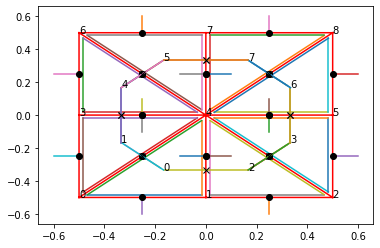

In [4]:
V, T = make_beam_mesh(1.0,1.0,(2,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='r')
for v in range(len(V)):
    print('vertex ',v , ' has triangle neighbors ',info.get_triangles_of_vertex(v))
    plt.text(info.V[v,0],info.V[v,1], str(v))
for t in range(len(T)):
    print('Triangle ',t , ' has triangle neighbors ',info.get_triangles_of_triangle(t))
    c = info.get_triangle_center(t)
    plt.text(c[0],c[1], str(t))
for v in range(len(V)):
    print('vertex ',v , ' has vertex neighbors ',info.get_vertices_of_vertex(v))
for t in range(len(T)):
    c = info.get_triangle_center(t)
    for e in range(3):
        u, m = info.get_edge_vector_of_triangle(t,e)
        v = m - 0.5*u
        w = m + 0.5*u
        m = (m-c)*0.9 + c
        v = (v-c)*0.9 + c
        w = (w-c)*0.9 + c
        plt.plot([v[0], w[0]], [v[1], w[1]] )
for t in range(len(T)):
    for e in range(3):
        n, m = info.get_outward_normal_of_triangle(t,e)
        plt.plot([m[0], 0.1*n[0]+m[0]], [m[1], 0.1*n[1]+m[1]] )
        plt.plot(m[0], m[1],'ko')
for t in range(len(T)):
    for e in range(3):
        u, m = info.get_triangle_triangle_segment(t,e)
        if not u is None: 
            v = m - 0.5*u
            w = m + 0.5*u
            plt.plot([v[0], w[0]], [v[1], w[1]] )
            plt.plot(m[0], m[1],'kx')
plt.show()    

# Creating Vertex-centered Control Volumes
We may now use the mesh information functionality to quickly generate a simple control volume data structure.

We will take a rather brute-force approach and simply create a chunk of vertex-related information that is very specific to the simulation method we will immplement here.

We will exploit one very smart trick here which is to make a cyclic permulation a local copy of neighboring triangles such that the first index of each triangle is the vertex that they all have in common.

This is cleaver later on at run-time as we have explicit knowledge of where the two other vertices of each triangle is located in the vertex neighborhood. Further, it enable us to deduce a CCW order of triangles around a vertex. Although in this example we have little use of this knowledge.

In [5]:
def get_cyclic_permuation(v, triangle):
    i = triangle[0]
    j = triangle[1]
    k = triangle[2]
    if i==v:
        return [i, j, k]
    if j==v:
        return [j, k, i]
    if k==v:
        return [k, i, j]
    return [-1, -1, -1]


def get_ccw_triangle_order(v, T):
    for t in range(len(T)):
        T[t,:] = get_cyclic_permuation(v, T[t,:])    
    if len(T) == 1:
        ccw_order = np.array([0], dtype=np.int).flatten()
    else:
        ccw_order = []
        next_order = -np.ones( (len(T), ), dtype=np.int )
        prev_order = -np.ones( (len(T), ), dtype=np.int )
        for s in range(len(T)):
            A = T[s,:]
            for t in range(len(T)):
                B = T[t,:]
                if A[2]==B[1]:
                    next_order[s] = t
                if A[1]==B[2]:
                    prev_order[s] = t
        if np.any(prev_order<0):
            i = np.where(prev_order<0)[0]
            while i>=0:
                ccw_order.append(i)
                i = next_order[i]
        else:
            i = 0
            ccw_order.append(i)
            i = next_order[i]
            while i>0:
                ccw_order.append(i)
                i = next_order[i]            
        ccw_order = np.array(ccw_order, dtype=np.int).flatten()
    return ccw_order
    
    
class VertexControlVolume:

    def __init__(self, v, info):
        self.v = v
        self.c = info.V[v,:].flatten()
        self.labels = info.get_triangles_of_vertex(v)
        K = len(self.labels)        
        self.K = K
        self.boundary = info.is_boundary_vertex(v)
        
        T = info.T[self.labels,:]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])    
        
        self.Lij = np.zeros(( K, ), dtype=np.float64 )
        self.Lik = np.zeros(( K, ), dtype=np.float64 )
        self.Nij = np.zeros(( K, 2), dtype=np.float64 )
        self.Nik = np.zeros(( K, 2), dtype=np.float64 )
        self.Sij = np.zeros(( K, 2), dtype=np.float64 )
        self.Sik = np.zeros(( K, 2), dtype=np.float64 )
        self.P = np.zeros(( K, 2), dtype=np.float64 )
        self.A = np.sum(info.A[self.labels])/3.0
        for e in range(K):
            i = T[e,0]
            j = T[e,1]
            k = T[e,2]
            
            pi = info.V[i,:]
            pj = info.V[j,:]
            pk = info.V[k,:]
            
            Eij = (pj-pi)
            Lij = np.linalg.norm(Eij)
            Nij = -hat(Eij)/Lij
            
            Eik = (pk-pi)
            Lik = np.linalg.norm(Eik)
            Nik = hat(Eik)/Lik
        
            self.Lij[e] = Lij/2
            self.Lik[e] = Lik/2
            self.Nij[e,:] = Nij
            self.Nik[e,:] = Nik
            self.Sij[e,:] = Eij/2
            self.Sik[e,:] = Eik/2
            self.P[e,:] = (pi+pj+pk)/3

Now we will do a little debug rendering to test if the information in the new control volume is created correctly.

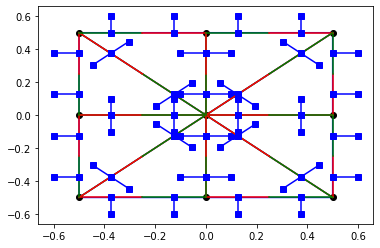

In [6]:
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)            

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='b')
for v in range(len(info.V)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    
    for e in range(cv.K):
        start = cv.c
        end = cv.c + cv.Sij[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
                   
        start = cv.c
        end = cv.c + cv.Sik[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-g')

        start = cv.c+cv.Sij[e]/2
        end = cv.c+cv.Sij[e]/2 + cv.Nij[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
                   
        start = cv.c+cv.Sik[e]/2
        end = cv.c+cv.Sik[e]/2 + cv.Nik[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
plt.show()    

Next will will render the control volume shapes so we can see how they look like. They have a very specific shape and it is easy to verify by visual inspection if they have been created correctly.

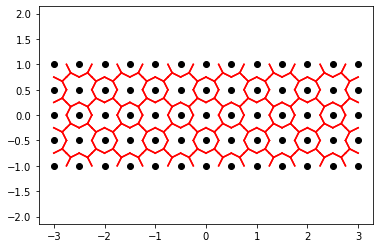

In [7]:
V, T = make_beam_mesh(6.0,2.0,(12,4))

info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

fig = plt.figure()
ax = plt.subplot(111)
for v in range(len(CVs)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    for e in range(cv.K):
        start = cv.c + cv.Sij[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
        start = cv.c + cv.Sik[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
ax.axis('equal')
plt.show()

# Creating a 2D Hyperelastic Simualtor

First we need to create a data structure for holding all values we needed to simulate an elastic body. 

Our simulation uses median dual vertec centered control volumes for computing/updating all vector quantities such as  the elastic forces and triangle element control volumes for computing all tensor values such as stress and strain tensors etc.

Hence, we need to add enough book-keepinng data-structure to access the vertex-centered control volume. However, we also need to store the triangle mesh info.

Further, the data structure must contain variables for all the kinematic and dynamic states of the elastic body. That is positions, velocities, forces and so on.

One particular trait of the type of simulator we are creating is that the inverse edge-vector matrix $D_0^{-1}$ can be precomputed from material space positions. This can save flops at run-time. Hence, these must be precomputed too.

We have choosen not to precompute the mass values of the control volumes because this allow us to keep material parameters strictly separate from this data-structure. Hence, given us more modular code.

This results in two main classes, one keeping the simulation state relevant data and the other keeping information about parameters used in the simulation.

In [8]:
class Parameters:
    
    def __init__(self, material='default'):
        library = { 'cartilage':(0.69e6, 0.018, 1000),
               'cortical bone': (16.16e9, 0.33, 1600),
               'cancellous bone': (452e6, 0.3, 1600),
               'rubber': (0.01e9, 0.48, 1050), #0.00082802073
               'concrete': (30e9, 0.20, 2320), #0.00002247138
               'copper': (125e9, 0.35, 8900),
               'steel': (210e9, 0.31, 7800), #0.00001557342
               'aluminium': (72e9, 0.34, 2700),
               'glass': ( 50e9,  0.18, 2190), #0.00001691155
               'default': (10e5,0.3,1000)} #0.0158113883
        E, nu, rho = library[material]
        self.E = E              # Young Modulus
        self.nu = nu            # Poisson ratio
        self.rho = rho          # Mass density
        self.lambda_ =  (E*nu) / ((1+nu)*(1-2*nu))  # Lame 1st
        self.mu_     =  E/(2*(1+nu))                # Lame 2nd
        self.g = 9.81                # Gravity
        self.c = 0.004 #0.0004              # vicous damping
        self.dt = 0.001              # Simulation time-step size
        self.T = 4.0                 # Total time to simulate
        self.fps = 30                # Frames per second 


In [9]:
class ElasticBody:
    
    def __init__(self, V, T):
        info = MeshInfo(V,T)
        self.CVs = []
        for v in range(len(V)):
            cv = VertexControlVolume(v,info)
            self.CVs.append(cv)            
        self.T = np.copy(T)                                      # Keep triangle mesh around
        self.p0 = np.copy(V)                                     # Material coordinates
        self.p  = np.copy(V)                                     # Spatial coordinates
        self.v  = np.zeros(V.shape,dtype=np.float64)    # Velocities
        self.f  = np.zeros(V.shape,dtype=np.float64)    # Total force
        self.f_ext = np.zeros(V.shape,dtype=np.float64) # External force
        self.fe  = np.zeros(V.shape,dtype=np.float64)   # Elastic force
        self.ft  = np.zeros(V.shape,dtype=np.float64)   # Nodal Traction forces
        self.m  = np.zeros(V.shape,dtype=np.float64)    # Control volume masses        
        self.invD0 = np.zeros((2,2*len(T)),dtype=np.float64)
        for e in range(len(T)):
            i = T[e,0]
            j = T[e,1]
            k = T[e,2]            
            p0i = self.p0[i,:]
            p0j = self.p0[j,:]
            p0k = self.p0[k,:]            
            D0ij = (p0j-p0i)
            D0ik = (p0k-p0i)    
            D0 = np.array([[ D0ij[0], D0ik[0]],[ D0ij[1],D0ik[1]]],dtype=np.float64)
            self.invD0[:,2*e:2*e+2] = np.linalg.inv(D0)            
        self.F = np.zeros((2,2*len(T)))  # Deformation gradients
        self.E = np.zeros((2,2*len(T)))  # Green Strain tensor
        self.S = np.zeros((2,2*len(T)))  # 2nd Piola Kirchoff stress tesnsor
        self.P = np.zeros((2,2*len(T)))  # 1st Piola Kirchoff stress tesnsor
        

We will need to apply Dirichlet boundary conditions to our simulations. Hence, we need a data structure for keeping track of these nodal Dirichlet conditions and functionality for applying the conditions too.

The data structure initializes the nodal Dirichlet conditions to be all mesh nodes that in material space is inside a given bounding box. The bounding box is specified by a minimum and maximum corner.

For now we hard-wire Dirichlet conditions to mean that positions stay fixed and velocities are always zero. This corresponds to fixating nodes in the mesh to their material coordinates.

In [10]:
class DirichletConditions:

    def __init__(self, body, min_coord, max_coord):        
        indices = []
        N = len(body.p0)
        for i in range(N):
            p = body.p0[i,:]
            if np.any(p<min_coord):
                continue
            if np.any(p>max_coord):
                continue
            indices.append(i)
        self.indices = np.array(indices, dtype=np.int)
        self.values = body.p0[indices,:]
        self.free = np.setdiff1d(np.arange(N), self.indices)


def apply_dirichlet_conditions(body, BC):
    body.p[BC.indices,:] = BC.values 
    body.v[BC.indices,:] = 0 

We use a similar design to create traction loads on the free boundary surface of the simulation object. We use a class to keep track of all boundary edges that are completely within a given material bounding box, and a free function that can compute the effect of the traction load.

In [11]:
class TractionConditions:
    
    def __init__(self, body, min_coord, max_coord, tx, ty):
        self.tx = tx
        self.ty = ty        
        B = igl.boundary_facets(body.T)
        N = len(B)
        indices = []
        for e in range(N):
            i = B[e,0]
            j = B[e,1]            
            pi = body.p0[i,:]
            pj = body.p0[j,:]            
            if np.any(pi<min_coord):
                continue
            if np.any(pi>max_coord):
                continue
            if np.any(pj<min_coord):
                continue
            if np.any(pj>max_coord):
                continue
            indices.append(e)            
        self.edges = B[indices,:]

During a simulation step we need to perform 9 sub-steps as outlined on page 21 in slides 21. We structure our code in such a way that we have a free function for each of the needed sub-steps. Each function takes as input the body that is to be simulated and computes the values of the specific sub-step and stores the result into the body data structure for later access.

This is a very modular way of implementing the simulation loop and it allow us to test each functionality individually.

It is not the most performance optimal implementation but it makes a more safe and convenient implementation possible.

In [12]:
def compute_mass(body, params):
    for v in range(len(body.CVs)):
        A0 = body.CVs[v].A
        mass = A0*params.rho
        body.m[v,:] = [mass,mass]
        
def compute_F(body):
    for e in range(len(body.T)):
        i = body.T[e,0]
        j = body.T[e,1]
        k = body.T[e,2]
            
        pi = body.p[i,:]
        pj = body.p[j,:]
        pk = body.p[k,:]
            
        Dij = (pj-pi)
        Dik = (pk-pi)
    
        D = np.array([[ Dij[0], Dik[0]],[ Dij[1], Dik[1]]],dtype=np.float64)
        invD0 = body.invD0[:,2*e:2*e+2]        
        F = np.dot(D, invD0)
        body.F[:,2*e:2*e+2] = F

        
def compute_E(body):
    I = np.eye(2, dtype=np.float64)
    for e in range(len(body.T)):
        F = body.F[:,2*e:2*e+2]
        C = np.dot(np.transpose(F),F)
        E = (C - I)/2
        body.E[:,2*e:2*e+2] = E
    
    
def compute_S(body, params):
    I = np.eye(2, dtype=np.float64)
    for e in range(len(body.T)):
        E = body.E[:,2*e:2*e+2]
        S = params.lambda_*np.trace(E)*I + 2*params.mu_*E
        body.S[:,2*e:2*e+2] = S

        
def compute_P(body):
    for e in range(len(body.T)):
        F = body.F[:,2*e:2*e+2]
        S = body.S[:,2*e:2*e+2]
        P = np.dot(F,S)
        body.P[:,2*e:2*e+2] = P
    
    
def compute_fe(body):    
    for v in range(len(body.CVs)):
        cv = body.CVs[v]
        f = np.zeros((2,),dtype=np.float64)
        for e in range(cv.K):
            l = cv.labels[e]
            P = body.P[:, 2*l : 2*l + 2]
            Lij = cv.Lij[e]
            Lik = cv.Lik[e]
            Nij = cv.Nij[e,:]
            Nik = cv.Nik[e,:]
            f = f - np.dot(P,Nij)*Lij - np.dot(P,Nik)*Lik
        body.fe[v,:] = f

        
def compute_f_traction(body, TC):
    body.ft = np.zeros(body.ft.shape,dtype=np.float64)
    for e in range(len(TC.edges)):
        i = TC.edges[e,0]
        j = TC.edges[e,1]
        pi = body.p[i,:]
        pj = body.p[j,:]
        f = np.linalg.norm(pj-pi)*vec2(TC.tx,TC.ty)     
        body.ft[i,:] = body.ft[i,:] + f/2
        body.ft[j,:] = body.ft[j,:] + f/2
        
        
def compute_f_ext(body, params):
    for v in range(len(body.CVs)):
        gravity = vec2(0, -params.g*body.m[v,1])
        damping = -params.c * body.v[v]
        body.f_ext[v] = gravity + damping
        
        
def compute_f_total(body):
    body.f = body.f_ext + body.fe + body.ft
    
    
def velocity_update(body, dt):
    body.v = body.v + np.divide(body.f,body.m)*dt
    
    
def position_update(body, dt):
    body.p = body.p + body.v*dt

During simulation we wish to monitor how the physics behaves. One good approach to this is to record the mechanical energy as a function of time, and also how it is split into different energy terms such as kinetic, potential and elastic energies.

In [13]:
def compute_kinetic_energy(body, params):
    vx = body.v[:,0]
    vy = body.v[:,1]
    m = body.m[:,0]
    Ekin = (np.dot(vx, np.multiply(m,vx)) +np.dot(vy, np.multiply(m,vy)))/2
    return Ekin


def compute_potential_energy(body, params):
    h = body.p[:,1]
    m = body.m[:,0]
    Epot = params.g * np.dot(m, h)
    return Epot
    
    
def compute_strain_energy(body, params):
    A = compute_triangle_areas(body.p0, body.T)
    Estrain = 0
    for e in range(len(body.T)):
        E = body.E[:, e*2:e*2+2]
        Ae = A[e]
        E2 = np.dot(np.transpose(E),E)
        We = (params.lambda_/2)*np.trace(E)**2 + params.mu_* np.trace(E2)
        Estrain = Estrain + We*Ae
    return Estrain

We now have all the sub-step pieces available to put them together into a time-step function and further add higher level logic to create a simulation loop that consist of taking several small time-steps.

If we want simpler logic we can just loop a fixed number of time-step with a fixed size too

<code>for i in range(100):
    fixed_time_step(body,BC,params, 0.001)</code>

However, a simulation loop offers a bit more control over framerate. It is also very convenient for us to measure energies while we simulate and return the measured energy once simualtion is done.

Energy plots are very useful to reason about he physicla behavior in the system.

In [90]:
def save_film(body,idx):
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.triplot(body.p0[:,0],body.p0[:,1], body.T,'-k')
    plt.triplot(body.p[:,0],body.p[:,1], body.T,'-b')
    plt.plot(BC.values[:,0],BC.values[:,1],'ro')
    plt.plot(np.arange(-3,4),np.ones(7)*-3)
    # plt.quiver(body.p[:,0],body.p[:,1],body.f_ext[:,0],body.f_ext[:,1],color='red',label='external')
    # plt.quiver(body.p[:,0],body.p[:,1],body.fe[:,0],body.fe[:,1],color='green',label='elastic')
    # plt.quiver(body.p[:,0],body.p[:,1],body.v[:,0],body.v[:,1],color='blue',label='velocity')
    # plt.quiver(body.p[:,0],body.p[:,1],body.ft[:,0],body.ft[:,1],color='magenta',label='traction')
    ax.axis('equal')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    #ax.legend()
    #plt.show()
    plt.savefig("film/movie%d.png" % idx)
    plt.close()

In [15]:
def fixed_time_step(body,BC, TC, params, dt):
    compute_mass(body, params) # Ideally this step can be done as a pre-processing step to save run-time floops.
    compute_F(body)
    compute_E(body)
    compute_S(body, params)
    compute_P(body)
    compute_fe(body)
    compute_f_traction(body, TC)
    compute_f_ext(body, params)
    compute_f_total(body)
    velocity_update(body, dt)
    apply_dirichlet_conditions(body, BC)
    position_update(body, dt)
    # Let us compute energy terms for verifying physics
    Ekin = compute_kinetic_energy(body,params)
    Epot = compute_potential_energy(body,params)
    Estrain = compute_strain_energy(body,params)
    return Ekin, Epot, Estrain


def simulate(body, BC, TC, params):
    count = 0
    E = []
    t = 0;
    dt_fps = 1.0/params.fps
    T_left = params.T
    while T_left>0:
        save_film(body,count)
        dT = np.min([dt_fps, T_left])
        dT_left = dT
        while dT_left>0:
            dt = np.min([params.dt,dT_left])            
            Ekin, Epot, Estrain = fixed_time_step(body, BC, TC, params, dt)
            t = t + dt
            E.append( [t, Ekin, Epot, Estrain] )
            dT_left = dT_left - dt
        T_left = T_left - dT
        count += 1
    return np.array(E,dtype=np.float64) 

Now we can setup our first test scene. This consist of a cantilever scene in a weak gravitational field

hort = np.repeat(length < minsh, 8, axis=1)
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:767: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplo

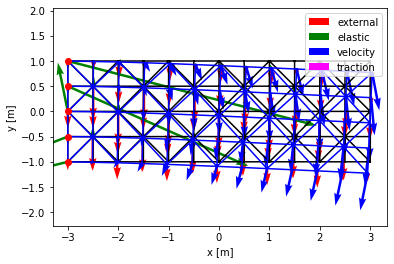

In [39]:
params = Parameters('default')
params.g = 1.0   # Make gravity weak

V, T = make_beam_mesh(6.0,2.0,(12,4))

body = ElasticBody(V,T)

BC = DirichletConditions(body, vec2(-3.1,-1.1),vec2(-2.9,1.1))
# Force the Traction conditions to be empty
TC = TractionConditions(body, vec2(-100.1,-1.1), vec2(-99.9,1.1), 0, -5)

E = simulate(body,BC,TC,params)

fig = plt.figure()
ax = plt.subplot(111)
plt.triplot(body.p0[:,0],body.p0[:,1], body.T,'-k')
plt.triplot(body.p[:,0],body.p[:,1], body.T,'-b')
plt.plot(BC.values[:,0],BC.values[:,1],'ro')
plt.quiver(body.p[:,0],body.p[:,1],body.f_ext[:,0],body.f_ext[:,1],color='red',label='external')
plt.quiver(body.p[:,0],body.p[:,1],body.fe[:,0],body.fe[:,1],color='green',label='elastic')
plt.quiver(body.p[:,0],body.p[:,1],body.v[:,0],body.v[:,1],color='blue',label='velocity')
plt.quiver(body.p[:,0],body.p[:,1],body.ft[:,0],body.ft[:,1],color='magenta',label='traction')
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()
plt.show()

In [25]:
%%bash 
ffmpeg -r 30 -i film/movie%d.png -c:v libx264 -vf fps=30 -pix_fmt yuv420p out.mp4

bash: line 1: ffmpeg: command not found


CalledProcessError: Command 'b'ffmpeg -r 30 -i film/movie%d.png -c:v libx264 -vf fps=30 -pix_fmt yuv420p out.mp4\n'' returned non-zero exit status 127.

Let us quickly investigate the energy conservation of this example

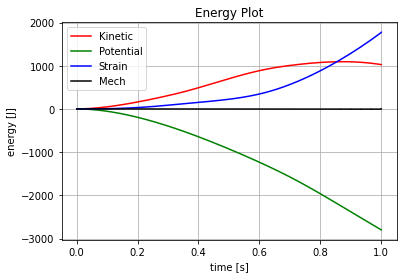

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(E[:,0], E[:,1],'-r',label='Kinetic')
plt.plot(E[:,0], E[:,2],'-g',label='Potential')
plt.plot(E[:,0], E[:,3],'-b',label='Strain')
plt.plot(E[:,0], (E[:,1]+E[:,2]+E[:,3]),'-k',label='Mech')
ax.set_xlabel('time [s]')
ax.set_ylabel('energy [J]')
ax.legend()
ax.set_title('Energy Plot')
ax.grid(True)
plt.show()

Now we will test another scenario of a free floating beam that has been slightly initially extended in teh x-direction. We have carefully orchested the setup to make sure we have a completely symmetric simulation in the $x$ and $y$ directions. Hence, after a certain about of simulation we expect to have a symmetric behavior of the beam and we also expect that it like a rubber band will try and move towards its equilibrium position defined by the material coordinate rest pose.

Observe, we added some slight viscous damping to remove kinetic energy from the system. If we did not do this then we would have a beam that would oscilate back and forth almost infinitely long.

hort = np.repeat(length < minsh, 8, axis=1)
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:767: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplo

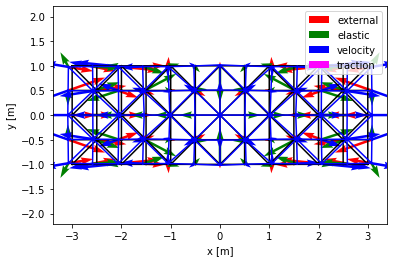

In [42]:
params = Parameters('default')
params.g = 0.0   # Turn gravity off

V, T = make_beam_mesh(6.0,2.0,(12,4))

body = ElasticBody(V,T)

# Force the Dirichlet conditions to be empty
BC = DirichletConditions(body, vec2(-100,-1.1),vec2(-99,1.1))
# Force the Traction conditions to be empty
TC = TractionConditions(body, vec2(-100.1,-1.1),vec2(-99.9,1.1), 0, 0)

# Enlarge beam slightly in the x-direction
body.p[:,0] = body.p[:,0]*1.05

# Run simulation
E = simulate(body,BC,TC,params)

# Plot final result
fig = plt.figure()
ax = plt.subplot(111)
plt.triplot(body.p0[:,0],body.p0[:,1], body.T,'-k')
plt.triplot(body.p[:,0],body.p[:,1], body.T,'-b')
plt.plot(BC.values[:,0],BC.values[:,1],'ro')
plt.quiver(body.p[:,0],body.p[:,1],body.f_ext[:,0],body.f_ext[:,1],color='red',label='external')
plt.quiver(body.p[:,0],body.p[:,1],body.fe[:,0],body.fe[:,1],color='green',label='elastic')
plt.quiver(body.p[:,0],body.p[:,1],body.v[:,0],body.v[:,1],color='blue',label='velocity')
plt.quiver(body.p[:,0],body.p[:,1],body.ft[:,0],body.ft[:,1],color='magenta',label='traction')
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()
plt.show()

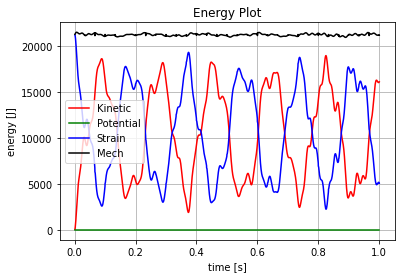

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(E[:,0], E[:,1],'-r',label='Kinetic')
plt.plot(E[:,0], E[:,2],'-g',label='Potential')
plt.plot(E[:,0], E[:,3],'-b',label='Strain')
plt.plot(E[:,0], (E[:,1]+E[:,2]+E[:,3]),'-k',label='Mech')
ax.set_xlabel('time [s]')
ax.set_ylabel('energy [J]')
ax.legend()
ax.set_title('Energy Plot')
ax.grid(True)
plt.show()

The final test configuartion is a gravity free cantilever beam that is being pullled own by a traction load.

  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:767: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/Shared/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Shared/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: Runt

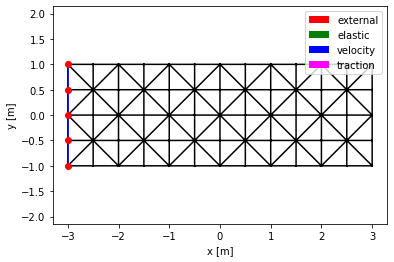

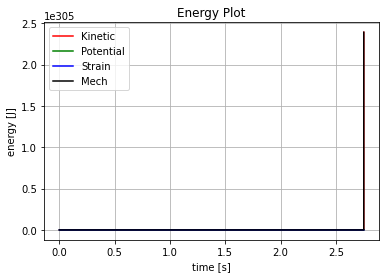

In [65]:
params = Parameters('steel')
params.g = 0.0   # Turn gravity off
params.T = 4.0
params.dt = 0.00005
            #0.00009636241

V, T = make_beam_mesh(6.0,2.0,(12,4))

body = ElasticBody(V,T)

BC = DirichletConditions(body, vec2(-3,-1.1),vec2(-2.9,1.1))
TC = TractionConditions(body, vec2(2.9,-1.1),vec2(3.0,1.1), 0, -5e8)

# Run simulation
E = simulate(body,BC,TC,params)

# Plot final result
fig = plt.figure()
ax = plt.subplot(111)
plt.triplot(body.p0[:,0],body.p0[:,1], body.T,'-k')
plt.triplot(body.p[:,0],body.p[:,1], body.T,'-b')
plt.plot(BC.values[:,0],BC.values[:,1],'ro')
plt.quiver(body.p[:,0],body.p[:,1],body.f_ext[:,0],body.f_ext[:,1],color='red',label='external')
plt.quiver(body.p[:,0],body.p[:,1],body.fe[:,0],body.fe[:,1],color='green',label='elastic')
plt.quiver(body.p[:,0],body.p[:,1],body.v[:,0],body.v[:,1],color='blue',label='velocity')
plt.quiver(body.p[:,0],body.p[:,1],body.ft[:,0],body.ft[:,1],color='magenta',label='traction')
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()
plt.show()

# Plot energy analysis
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(E[:,0], E[:,1],'-r',label='Kinetic')
plt.plot(E[:,0], E[:,2],'-g',label='Potential')
plt.plot(E[:,0], E[:,3],'-b',label='Strain')
plt.plot(E[:,0], (E[:,1]+E[:,2]+E[:,3]),'-k',label='Mech')
ax.set_xlabel('time [s]')
ax.set_ylabel('energy [J]')
ax.legend()
ax.set_title('Energy Plot')
ax.grid(True)
plt.show()

That is all folks!

In [89]:
def collission_update(body):
    ground = -3
    for i in range(len(body.p)):
        if (body.p[i,1] < ground):
            body.p[i,1] = ground
            body.v[i,1] = 0

In [79]:
def fixed_time_step_impact(body,BC, TC, params, dt):
    compute_mass(body, params) # Ideally this step can be done as a pre-processing step to save run-time floops.
    compute_F(body)
    compute_E(body)
    compute_S(body, params)
    compute_P(body)
    compute_fe(body)
    compute_f_traction(body, TC)
    compute_f_ext(body, params)
    compute_f_total(body)
    velocity_update(body, dt)
    apply_dirichlet_conditions(body, BC)
    position_update(body, dt)

    collission_update(body)
    # Let us compute energy terms for verifying physics
    Ekin = compute_kinetic_energy(body,params)
    Epot = compute_potential_energy(body,params)
    Estrain = compute_strain_energy(body,params)
    return Ekin, Epot, Estrain


def simulate_impact(body, BC, TC, params):
    count = 0
    pos = []
    E = []
    t = 0;
    dt_fps = 1.0/params.fps
    T_left = params.T
    while T_left>0:
        # if count == 2:
        #     TC = TractionConditions(body, vec2(-100.1,-1.1),vec2(-99.9,1.1), 0, 0)
        save_film(body,count)
        dT = np.min([dt_fps, T_left])
        dT_left = dT
        while dT_left>0:
            #pos.append(body.p[78,1])
            dt = np.min([params.dt,dT_left])            
            Ekin, Epot, Estrain = fixed_time_step_impact(body, BC, TC, params, dt)
            t = t + dt
            E.append( [t, Ekin, Epot, Estrain] )
            dT_left = dT_left - dt
        T_left = T_left - dT
        count += 1
    return np.array(E,dtype=np.float64)#,pos

In [129]:
params = Parameters('concrete')
params.g = 9.81
params.T = 1.0
params.dt = 0.0000205

#V, T = make_beam_mesh(6.0,2.0,(78,26))
V, T = make_circle_mesh(0.75, 36)

body = ElasticBody(V,T)

# Square
# BC = DirichletConditions(body, vec2(-100,-1.1),vec2(-99,1.1))
# TC = TractionConditions(body, vec2(-3.1,-1.1),vec2(3.1,-0.9), 0, -8e5)

# Circle
#BC = DirichletConditions(body, vec2(-3.1,-1.1),vec2(-2.9,1.1))
BC = DirichletConditions(body, vec2(-100,-1.1),vec2(-99,1.1))
TC = TractionConditions(body, vec2(-1,-0.8),vec2(1,-0.7), 0, 0)

# Run simulation
E = simulate_impact(body,BC,TC,params)
print(np.min(pos))

# # Plot final result
# fig = plt.figure()
# ax = plt.subplot(111)
# plt.triplot(body.p0[:,0],body.p0[:,1], body.T,'-k')
# plt.triplot(body.p[:,0],body.p[:,1], body.T,'-b')
# plt.plot(BC.values[:,0],BC.values[:,1],'ro')
# plt.quiver(body.p[:,0],body.p[:,1],body.f_ext[:,0],body.f_ext[:,1],color='red',label='external')
# plt.quiver(body.p[:,0],body.p[:,1],body.fe[:,0],body.fe[:,1],color='green',label='elastic')
# plt.quiver(body.p[:,0],body.p[:,1],body.v[:,0],body.v[:,1],color='blue',label='velocity')
# plt.quiver(body.p[:,0],body.p[:,1],body.ft[:,0],body.ft[:,1],color='magenta',label='traction')
# ax.axis('equal')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')
# ax.legend()
# plt.show()

# # Plot energy analysis
# fig = plt.figure()
# ax = plt.subplot(111)
# plt.plot(E[:,0], E[:,1],'-r',label='Kinetic')
# plt.plot(E[:,0], E[:,2],'-g',label='Potential')
# plt.plot(E[:,0], E[:,3],'-b',label='Strain')
# plt.plot(E[:,0], (E[:,1]+E[:,2]+E[:,3]),'-k',label='Mech')
# ax.set_xlabel('time [s]')
# ax.set_ylabel('energy [J]')
# ax.legend()
# ax.set_title('Energy Plot')
# ax.grid(True)
# plt.show()

KeyboardInterrupt: 

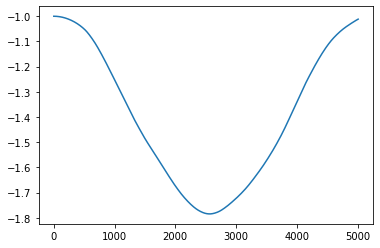

In [35]:
plt.plot(np.arange(0,len(pos)),pos)

No handles with labels found to put in legend.


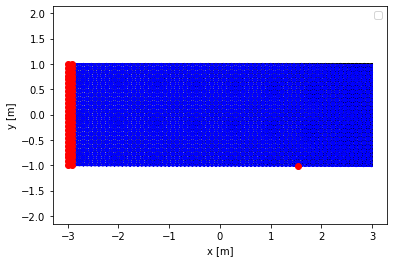

In [77]:
#V, T = make_beam_mesh(6.0,2.0,(48,16))
V, T = make_circle_mesh(0.75, 36)

# Plot final result
fig = plt.figure()
ax = plt.subplot(111)
plt.triplot(body.p0[:,0],body.p0[:,1], body.T,'-k')
plt.triplot(body.p[:,0],body.p[:,1], body.T,'-b')
plt.plot(BC.values[:,0],BC.values[:,1],'ro')
plt.plot([body.p[59,0]],[body.p[59,1]],'ro')
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()
plt.show()

body = ElasticBody(V,T)

In [78]:
minlen = np.inf
for t in body.T:
    pi = body.p0[t[0]]
    pj = body.p0[t[1]]
    pk = body.p0[t[2]]
    lij = np.linalg.norm(pi-pj)
    lik = np.linalg.norm(pi-pk)
    lkj = np.linalg.norm(pk-pj)
    if(minlen > lij):
        minlen = lij
    if(minlen > lik):
        minlen = lik
    if(minlen > lkj):
        minlen = lkj
print(minlen)

0.08080654918339523


In [76]:
# Documentation is here https://wildmeshing.github.io/wildmeshing-notebook/
def make_circle_mesh(radius, segments):
    K = segments
    X = np.array([ radius*np.cos(2*np.pi*k/K) for k in range(K)])
    Y = np.array([ radius*np.sin(2*np.pi*k/K) for k in range(K)])
    P = np.zeros((K,2))
    P[:,0] = X
    P[:,1] = Y
    L = np.array([(k,(k+1)%K) for k in range(K)],dtype=np.int32)
    V, T, _, _ = wm.triangulate_data(P, L, cut_outside=True)
    return (V, T)

V, T = make_circle_mesh(0.75, 36)
p = mp.plot(V, T, return_plot=True, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

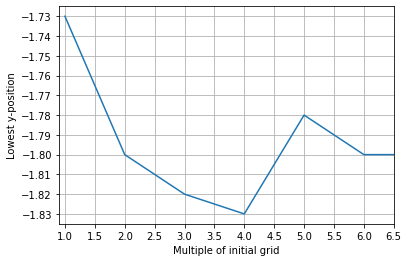

In [75]:
#12,24,36,48,60,72,76
y = [-1.73,-1.80,-1.82,-1.83, -1.78, -1.80,-1.80]
X = np.arange(1,len(y)+1)
fig,ax = plt.subplots()
ax.plot(X,y)
ax.set_xlabel('Multiple of initial grid')
ax.set_ylabel('Lowest y-position')
ax.set_xticks(np.arange(1,7,0.5))
ax.set_xlim(0.9,6.5)
ax.set_yticks(np.arange(-1.73,-1.83,-0.01))
ax.grid()
plt.show()
